**How to use this script**

/!\ To run this script, you need a working version of python with **numpy** and **panda** libraries

1. Compile the cell of **import libraries**
2. Fill the **user defined** part as follows, and compile it :
    - For step1_in and step2_in :
        * put the names of the different countries/regions in the list countries
        * put the path to corresponding data files (those files must follow the template file -> see...)
        * set the number of timeseries which have a WEIGHT defined in N_ts variable
        * set the number of TD to compute
    - For step2_in only : 
        * put the path of the output of STEP_1 : TD_of_days.out
3. **Compile the functions**
4. **Call the functions**
    - REM : 
        * before to call the functions, one must close all the DATA.xls
        * before calling the function step2_in, one must run the clustering method of STEP_1
        * for clustering method don't forget to update the set DIMENSIONS in the TD_main.mod and to delete the TD_of_days.out file

> Recipe to add a timeseries :
> * add the times series columns into the DATA.xlsx in sheet '1.1 Time Series' (also better to update the sheet 1.2 c_p_t but it will work without it)
> * if this timeseries should be used for TD clustering,
>   * add a line to the weights in sheet '2.2 User defined' with the exact same name as the column.
>   * change N_ts value in this script
>   * add the names of the ts and its coresponding parameter either to EUD_params, or RES_params, or RES_mult_params according to which category it corresponds
> * Run the script according to the explanations here above

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import time
import csv

In [2]:
import matplotlib.pyplot as plt

# User Defined

## Data for reading files

In [10]:
## for step1_in and step2_in ##
countries = ['NO', 'CN', 'SO'] # countries list
data = ['Data\\DATA_NO_3C.xlsx', 'Data\\DATA_CN_3C.xlsx', 'Data\\DATA_SO_3C.xlsx'] # data path (in same order as data path)
N_ts = 7 # number of timeseries with a WEIGHT defined (per country)
Nbr_TD = 12 # number of typical day

In [12]:
## for step2_in ##
step1_out = 'STEP_1_TD_selection\TD_of_days.out'
## name of timeseries in DATA.xlsx and corresponding name in ESTD data file
# for EUD timeseries
EUD_params = {'Electricity (%_elec)' : 'param electricity_time_series :=', 'Space Heating (%_sh)' : 'param heating_time_series :=', 'Space Cooling (%_sc)':'param cooling_time_series :=', 'Passanger mobility (%_pass)' : 'param mob_pass_time_series :=', 'Freight mobility (%_freight)' : 'param mob_freight_time_series :='}
# for resources timeseries that have only 1 tech linked to it
RES_params = {'PV' : 'PV', 'Wind_offshore' : 'WIND_OFFSHORE', 'Wind_onshore': 'WIND_ONSHORE'}
# for resources timeseries that have several techs linked to it
RES_mult_params = {'HYDRO_DAM' : ['HYDRO_DAM'], 'HYDRO_RIVER' : ['HYDRO_RIVER'], 'SOLAR' : ['DHN_SOLAR', 'DEC_SOLAR']}

# Compiling the functions

## From DATA to STEP_1_in

In [22]:
def step1_in(out_path,countries,data, N_ts=6, Nbr_TD=12):
    "step1_in reads the datas at the path of data and prints the Ndata param in Ndata.tsv and the list of timeseries used in this Ndata with their weights and norm"
    N_c = len(data) #number of countries
    
    ## READ FIRST COUNTRY ##
    #reading the weights
    weights = pd.read_excel(data[0],  sheet_name='2.2 User defined',  header=[2], index_col=0, nrows = N_ts, usecols = [0,1] ).rename(columns={'Unnamed: 1':'Weights'})
    weights.index.rename('Category', inplace=True)
    # from weights, create the names of ts for STEP1 and number of ts
    ts_names = list(weights.index)

    #reading the timeseries
    timeseries =  pd.read_excel(data[0],  sheet_name='1.1 Time Series',  header=[1], index_col=0, nrows = 8760 )
    timeseries.drop(labels='period_duration [h]', axis=1, inplace=True)

    # adding the country suffix
    ts_names_all = [str(x)+'_'+countries[0] for x in ts_names]
    weights.index =  [str(line) + '_' + countries[0] for line in weights.index]
    timeseries.columns = [str(col) + '_' + countries[0] for col in timeseries.columns]
    
    ## READING THE OTHER COUNTRIES ##
    for i in np.arange(1,N_c):
        #reading the weights
        weights2 = pd.read_excel(data[i],  sheet_name='2.2 User defined',  header=[2], index_col=0, nrows = N_ts, usecols = [0,1] ).rename(columns={'Unnamed: 1':'Weights'})
        weights2.index =  [str(line) + '_' + countries[i] for line in weights2.index]
        weights = pd.concat([weights, weights2]) #weights = weights.merge(pd.read_excel(data[i],  sheet_name='2.2 User defined',  header=[4], index_col=0, nrows = N_ts, usecols = [0,1] ).rename(columns={'Unnamed: 1':'Weights_'+countries[i]}), left_index=True, right_index=True)
        # adding the names of each country's columns that have a weight
        ts_names_all = ts_names_all + [str(x)+'_'+countries[i] for x in ts_names]
        #reading the timeseries
        ts2 = pd.read_excel(data[i],  sheet_name='1.1 Time Series',  header=[1], index_col=0, nrows = 8760).drop(labels='period_duration [h]', axis=1)
        ts2.columns = [str(col) + '_' + countries[i] for col in ts2.columns]
        timeseries = timeseries.merge(ts2, left_index=True, right_index=True)
    
    ## NORMALIZING TIMESERIES ##
    #compute norm = sum(ts)
    norm = timeseries.sum(axis=0)
    norm.index.rename('Category', inplace=True)
    norm.name = 'Norm'
    # normalise ts to have sum(norm_ts)=1
    norm_ts = timeseries/norm
    # fill NaN with 0
    norm_ts.fillna(0, inplace=True)
    
    ## WEIGHTING TIMESERIES ##
    weights = pd.Series(data=weights['Weights'], index=weights.index)
    weights.index.rename('Category', inplace=True)
    # select columns of ts that matters for STEP1
    weight_ts = norm_ts[ts_names_all]
    # multiply each timeserie by its weight
    weight_ts = weight_ts*weights
    
    ## CREATING DAY AND HOUR COLUMNS (for later pivoting) ##
    # creating df with 2 columns : day of the year | hour in the day
    day_and_hour_array = np.ones((24*365,2))
    for i in range(365):
        day_and_hour_array[i*24:(i+1)*24,0] = day_and_hour_array[i*24:(i+1)*24,0]*(i+1)
        day_and_hour_array[i*24:(i+1)*24,1] = np.arange(1,25,1)
    day_and_hour = pd.DataFrame(day_and_hour_array, index = np.arange(1,8761,1), columns=['D_of_H','H_of_D'])
    day_and_hour = day_and_hour.astype('int64')
    # merge day_and_hour with weight_ts for later pivot
    weight_ts = weight_ts.merge(day_and_hour,left_index=True, right_index=True)
    
    ## CREATING NDATA ##
    # pivoting timeseries to get Ndata (but not normalised and weighted)
    Ndata = weight_ts.pivot(index='D_of_H', columns='H_of_D', values=ts_names_all)
    # renumeroting Ndata columns
    Ndata.columns = np.arange(1,24*N_ts*N_c+1)
    # adding AMPL syntax for param Ndata
    Ndata.rename(columns = {Ndata.shape[1]:str(Ndata.shape[1])+' '+':='}, inplace=True)
    
    ## PRINTING NDATA AND WEIGHTS AND NORMS ##
   
    
    with open(out_path, mode='w',newline='') as TD_file:
        TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)

        TD_writer.writerow(['# -------------------------------------------------------------------------------------------------------------------------	'])
        TD_writer.writerow(['#	EnergyScope TD is an open-source energy model suitable for country scale analysis. It is a simplified representation of an urban or national energy system accounting for the energy flows'])
        TD_writer.writerow(['#	within its boundaries. Based on a hourly resolution, it optimises the design and operation of the energy system while minimizing the cost of the system.'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	Copyright (C) <2018-2019> <Ecole Polytechnique Fédérale de Lausanne (EPFL), Switzerland and Université catholique de Louvain (UCLouvain), Belgium>'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	Licensed under the Apache License, Version 2.0 (the "License");'])
        TD_writer.writerow(['#	you may not use this file except in compliance with the License.'])
        TD_writer.writerow(['#	You may obtain a copy of the License at'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	http://www.apache.org/licenses/LICENSE-2.0'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	Unless required by applicable law or agreed to in writing, software'])
        TD_writer.writerow(['#	distributed under the License is distributed on an "AS IS" BASIS,'])
        TD_writer.writerow(['#	WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.'])
        TD_writer.writerow(['#	See the License for the specific language governing permissions and'])
        TD_writer.writerow(['#	limitations under the License.'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	Description and complete License: see LICENSE file.'])
        TD_writer.writerow(['# -------------------------------------------------------------------------------------------------------------------------	'])
        TD_writer.writerow(['	'])
        TD_writer.writerow(['# SETS depending on TD	'])
        TD_writer.writerow(['# --------------------------	'])
        TD_writer.writerow(['param Nbr_TD :=	'+str(Nbr_TD)])
        TD_writer.writerow([';		'])
        TD_writer.writerow(['		'])
        
    # concatenating and printing weights and norm
    weight_norm = pd.concat([weights, norm[ts_names_all]], axis=1)
    weight_norm.reset_index(inplace=True)
    weight_norm['#'] = '#'
    weight_norm = weight_norm[['#', 'Category', 'Weights', 'Norm']]
    weight_norm.to_csv(out_path, sep='\t', header=True, index=False, mode='a')
    
    with open(out_path, mode='a',newline='') as TD_file:
        TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        TD_writer.writerow([''])
    
    # printing param Ndata
    Ndata.to_csv(out_path, sep='\t', header=True, index=True, index_label='param Ndata :', mode='a')
    
    with open(out_path, mode='a',newline='') as TD_file:
        TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        TD_writer.writerow([';'])
    

    return

## From STEP_1_out to STEP_2_in

In [6]:
def step2_in(out_path, countries, data, step1_out, EUD_params, RES_params, RES_mult_params, N_ts=6, Nbr_TD=12):
    ## READING OUTPUT OF STEP1 ##
    TD_of_days = pd.read_csv(step1_out, names=['TD_of_days'])
    TD_of_days['day'] = np.arange(1,366,1) # putting the days of the year beside
    
    ## COMPUTING NUMBER OF DAYS REPRESENTED BY EACH TD ##
    sorted_TD = TD_of_days.groupby('TD_of_days').count()
    sorted_TD.rename(columns={'day':'#days'}, inplace=True)
    sorted_TD.reset_index(inplace=True)
    sorted_TD.set_index(np.arange(1,Nbr_TD+1), inplace=True) # adding number of TD as index
    
    ## BUILDING T_H_TD MATRICE ##
    # generate T_H_TD
    TD_and_hour_array = np.ones((24*365,2))
    for i in range(365):
        TD_and_hour_array[i*24:(i+1)*24,0] = np.arange(1,25,1)
        TD_and_hour_array[i*24:(i+1)*24,1] = TD_and_hour_array[i*24:(i+1)*24,1]*sorted_TD[sorted_TD['TD_of_days']==TD_of_days.loc[i,'TD_of_days']].index.values
    T_H_TD = pd.DataFrame(TD_and_hour_array, index = np.arange(1,8761,1), columns=['H_of_D','TD_of_day'])
    T_H_TD = T_H_TD.astype('int64')
    # giving the right syntax
    T_H_TD.reset_index(inplace=True)
    T_H_TD.rename(columns={'index':'H_of_Y'}, inplace=True)
    T_H_TD['par_g'] = '('
    T_H_TD['par_d'] = ')'
    T_H_TD['comma1'] = ','
    T_H_TD['comma2'] = ','
    # giving the right order to the columns
    T_H_TD = T_H_TD[['par_g','H_of_Y','comma1','H_of_D','comma2','TD_of_day','par_d']]
    
    ## READING THE TIMESERIES IN DATA FILE ##
    N_c = len(data) #number of countries
    # READ FIRST COUNTRY #
    #reading the timeseries
    timeseries =  pd.read_excel(data[0],  sheet_name='1.1 Time Series',  header=[1], index_col=0, nrows = 8760 )
    timeseries.drop(labels='period_duration [h]', axis=1, inplace=True)
    ts_names = list(timeseries.columns) # names of the columns
    timeseries.columns = [str(col) + '_' + countries[0] for col in timeseries.columns]

    # READING THE OTHER COUNTRIES #
    for i in np.arange(1,N_c):
        #reading the timeseries
        ts2 = pd.read_excel(data[i],  sheet_name='1.1 Time Series',  header=[1], index_col=0, nrows = 8760).drop(labels='period_duration [h]', axis=1)
        ts2.columns = [str(col) + '_' + countries[i] for col in ts2.columns]
        timeseries = timeseries.merge(ts2, left_index=True, right_index=True)

    # COMPUTING THE NORM OVER THE YEAR ##
    norm = timeseries.sum(axis=0)
    norm.index.rename('Category', inplace=True)
    norm.name = 'Norm'
    
    ## BUILDING TD TIMESERIES ##
    # creating df with 2 columns : day of the year | hour in the day
    day_and_hour_array = np.ones((24*365,2))
    for i in range(365):
        day_and_hour_array[i*24:(i+1)*24,0] = day_and_hour_array[i*24:(i+1)*24,0]*(i+1)
        day_and_hour_array[i*24:(i+1)*24,1] = np.arange(1,25,1)
    day_and_hour = pd.DataFrame(day_and_hour_array, index = np.arange(1,8761,1), columns=['D_of_H','H_of_D'])
    day_and_hour = day_and_hour.astype('int64')
    timeseries = timeseries.merge(day_and_hour,left_index=True, right_index=True)

    #selecting timeseries of TD only
    TD_ts = timeseries[timeseries['D_of_H'].isin(sorted_TD['TD_of_days'])]
    
    ## COMPUTING THE NORM_TD OVER THE YEAR FOR CORRECTION ##
    # computing the sum of ts over each TD
    agg_TD_ts = TD_ts.groupby('D_of_H').sum()
    agg_TD_ts.reset_index(inplace=True)
    agg_TD_ts.set_index(np.arange(1,Nbr_TD+1), inplace=True)
    agg_TD_ts.drop(columns=['D_of_H','H_of_D'], inplace=True)
    # multiplicating each TD by the number of day it represents
    for c in agg_TD_ts.columns:
        agg_TD_ts[c] = agg_TD_ts[c]*sorted_TD['#days']
    # sum of new ts over the whole year
    norm_TD = agg_TD_ts.sum()
    
    ## BUILDING THE DF WITH THE TS OF EACH TD FOR EACH CATEGORY ##
    # pivoting TD_ts to obtain a (24,Nbr_TD*Nbr_ts*N_c)
    all_TD_ts = TD_ts.pivot(index='H_of_D', columns='D_of_H')
    
    
    ## PRINTING ##
    # printing description of file
    with open(out_path, mode='w',newline='') as TD_file:
        TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)

        TD_writer.writerow(['# -------------------------------------------------------------------------------------------------------------------------	'])
        TD_writer.writerow(['#	EnergyScope TD is an open-source energy model suitable for country scale analysis. It is a simplified representation of an urban or national energy system accounting for the energy flows'])
        TD_writer.writerow(['#	within its boundaries. Based on a hourly resolution, it optimises the design and operation of the energy system while minimizing the cost of the system.'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	Copyright (C) <2018-2019> <Ecole Polytechnique Fédérale de Lausanne (EPFL), Switzerland and Université catholique de Louvain (UCLouvain), Belgium>'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	Licensed under the Apache License, Version 2.0 (the "License");'])
        TD_writer.writerow(['#	you may not use this file except in compliance with the License.'])
        TD_writer.writerow(['#	You may obtain a copy of the License at'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	http://www.apache.org/licenses/LICENSE-2.0'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	Unless required by applicable law or agreed to in writing, software'])
        TD_writer.writerow(['#	distributed under the License is distributed on an "AS IS" BASIS,'])
        TD_writer.writerow(['#	WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.'])
        TD_writer.writerow(['#	See the License for the specific language governing permissions and'])
        TD_writer.writerow(['#	limitations under the License.'])
        TD_writer.writerow(['#	'])
        TD_writer.writerow(['#	Description and complete License: see LICENSE file.'])
        TD_writer.writerow(['# -------------------------------------------------------------------------------------------------------------------------	'])
        TD_writer.writerow(['	'])
        TD_writer.writerow(['# SETS depending on TD	'])
        TD_writer.writerow(['# --------------------------	'])
        TD_writer.writerow(['param peak_sh_factor	:=	'])
        peak_sh_factor = 1
        for c in countries:
            max_sh_TD = TD_ts.loc[:,'Space Heating (%_sh)_'+c].max()
            max_sh_all = timeseries.loc[:,'Space Heating (%_sh)_'+c].max()
            peak_sh_factor = max_sh_all/max_sh_TD
            TD_writer.writerow([c + ' ' + str(peak_sh_factor)])
        TD_writer.writerow([';		'])
        TD_writer.writerow(['		'])
        TD_writer.writerow(['#SETS [Figure 3]		'])
        TD_writer.writerow(['set T_H_TD := 		'])
    
    # printing T_H_TD param
    T_H_TD.to_csv(out_path,sep='\t', header=False, index=False, mode='a', quoting=csv.QUOTE_NONE)
    
    # printing interlude
    with open(out_path, mode='a',newline='') as TD_file:
        TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)

        TD_writer.writerow([';'])
        TD_writer.writerow([''])
        TD_writer.writerow(['# -----------------------------'])
        TD_writer.writerow(['# PARAMETERS DEPENDING ON NUMBER OF TYPICAL DAYS : '])
        TD_writer.writerow(['# -----------------------------'])
        TD_writer.writerow([''])
        
    #if only 1 country
    if N_c==1:
        # printing EUD timeseries param
        for l in EUD_params.keys():
            with open(out_path, mode='a',newline='') as TD_file:
                TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
                TD_writer.writerow([EUD_params[l][0:-1]])    
            for c in countries:
                name = l+'_'+c
                ts = all_TD_ts[name]
                ts.columns = np.arange(1,Nbr_TD+1) 
                ts = ts*norm[name]/norm_TD[name]
                ts.fillna(0, inplace=True)
                ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
                ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='', mode='a', quoting=csv.QUOTE_NONE)
            with open(out_path, mode='a',newline='') as TD_file:
                TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
                TD_writer.writerow(';')
                TD_writer.writerow([''])

        # printing c_p_t param #
        with open(out_path, mode='a',newline='') as TD_file:
            TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
            TD_writer.writerow(['param c_p_t:='])    
        # printing c_p_t part where 1 ts => 1 tech
        for l in RES_params.keys():
            for c in countries:
                name = RES_params[l]+'_'+c
                ts = all_TD_ts[name]
                ts.columns = np.arange(1,Nbr_TD+1) 
                ts = ts*norm[name]/norm_TD[name]
                ts.fillna(0, inplace=True)
                ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
                ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + RES_params[l] + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)
        # printing c_p_t part where 1 ts => more then 1 tech        
        for l in RES_mult_params.keys():
            for j in RES_mult_params[l]:
                for c in countries:
                    name = l+'_'+c
                    ts = all_TD_ts[name]
                    ts.columns = np.arange(1,Nbr_TD+1) 
                    ts = ts*norm[name]/norm_TD[name]
                    ts.fillna(0, inplace=True)
                    ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
                    ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + j + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)

        with open(out_path, mode='a',newline='') as TD_file:
            TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
            TD_writer.writerow([';'])
    else:
        # printing EUD timeseries param
        for l in EUD_params.keys():
            with open(out_path, mode='a',newline='') as TD_file:
                TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
                TD_writer.writerow([EUD_params[l]])    
            for c in countries:
                name = l+'_'+c
                ts = all_TD_ts[name]
                ts.columns = np.arange(1,Nbr_TD+1) 
                ts = ts*norm[name]/norm_TD[name]
                ts.fillna(0, inplace=True)
                ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
                ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + c + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)
            with open(out_path, mode='a',newline='') as TD_file:
                TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
                TD_writer.writerow(';')
                TD_writer.writerow([''])

        # printing c_p_t param #
        with open(out_path, mode='a',newline='') as TD_file:
            TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
            TD_writer.writerow(['param c_p_t:='])    
        # printing c_p_t part where 1 ts => 1 tech
        for l in RES_params.values():
            for c in countries:
                name = l+'_'+c
                ts = all_TD_ts[name]
                ts.columns = np.arange(1,Nbr_TD+1) 
                ts = ts*norm[name]/norm_TD[name]
                ts.fillna(0, inplace=True)
                ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
                ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + l + '","' + c + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)
        # printing c_p_t part where 1 ts => more then 1 tech        
        for l in RES_mult_params.keys():
            for j in RES_mult_params[l]:
                for c in countries:
                    name = l+'_'+c
                    ts = all_TD_ts[name]
                    ts.columns = np.arange(1,Nbr_TD+1) 
                    ts = ts*norm[name]/norm_TD[name]
                    ts.fillna(0, inplace=True)
                    ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
                    ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + j + '","' + c + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)

        with open(out_path, mode='a',newline='') as TD_file:
            TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
            TD_writer.writerow([';'])
    return

# 4) Calling the functions

## From DATA to STEP_1_IN

In [8]:
out_path = 'STEP_1_TD_selection\data.dat'

In [23]:
start_time = time.time()
step1_in(out_path,countries, data, N_ts, Nbr_TD)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.133182764053345 seconds ---


## Getting the TD and the number of days they represent

In [27]:
## READING OUTPUT OF STEP1 ##
TD_of_days = pd.read_csv(step1_out, names=['TD_of_days'])
TD_of_days['day'] = np.arange(1,366,1) # putting the days of the year beside

## COMPUTING NUMBER OF DAYS REPRESENTED BY EACH TD ##
sorted_TD = TD_of_days.groupby('TD_of_days').count()
sorted_TD.rename(columns={'day':'#days'}, inplace=True)
sorted_TD.reset_index(inplace=True)
sorted_TD.set_index(np.arange(1,Nbr_TD+1), inplace=True) # adding number of TD as index
sorted_TD

,TD_of_days,#days
1,2,36
2,55,34
3,71,22
4,110,21
5,185,21
6,199,19
7,233,41
8,238,32
9,248,1
10,268,63


## From STEP_1_OUT to STEP_2_IN

In [28]:
## PRINTING 'ES_TD_'+str(Nbr_TD)+'TD.dat' ##
out_path = 'ESTD_'+str(Nbr_TD)+'TD_test.dat'

In [29]:
start_time = time.time()
step2_in(out_path, countries, data, step1_out, EUD_params, RES_params, RES_mult_params, N_ts, Nbr_TD)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.527782678604126 seconds ---


In [6]:
## READING OUTPUT OF STEP1 ##
TD_of_days = pd.read_csv(step1_out, names=['TD_of_days'])
TD_of_days['day'] = np.arange(1,366,1) # putting the days of the year beside

## COMPUTING NUMBER OF DAYS REPRESENTED BY EACH TD ##
sorted_TD = TD_of_days.groupby('TD_of_days').count()
sorted_TD.rename(columns={'day':'#days'}, inplace=True)
sorted_TD.reset_index(inplace=True)
sorted_TD.set_index(np.arange(1,Nbr_TD+1), inplace=True) # adding number of TD as index

## BUILDING T_H_TD MATRICE ##
# generate T_H_TD
TD_and_hour_array = np.ones((24*365,2))
for i in range(365):
    TD_and_hour_array[i*24:(i+1)*24,0] = np.arange(1,25,1)
    TD_and_hour_array[i*24:(i+1)*24,1] = TD_and_hour_array[i*24:(i+1)*24,1]*sorted_TD[sorted_TD['TD_of_days']==TD_of_days.loc[i,'TD_of_days']].index.values
T_H_TD = pd.DataFrame(TD_and_hour_array, index = np.arange(1,8761,1), columns=['H_of_D','TD_of_day'])
T_H_TD = T_H_TD.astype('int64')
# giving the right syntax
T_H_TD.reset_index(inplace=True)
T_H_TD.rename(columns={'index':'H_of_Y'}, inplace=True)
T_H_TD['par_g'] = '('
T_H_TD['par_d'] = ')'
T_H_TD['comma1'] = ','
T_H_TD['comma2'] = ','
# giving the right order to the columns
T_H_TD = T_H_TD[['par_g','H_of_Y','comma1','H_of_D','comma2','TD_of_day','par_d']]

## READING THE TIMESERIES IN DATA FILE ##
N_c = len(data) #number of countries
# READ FIRST COUNTRY #
#reading the timeseries
timeseries =  pd.read_excel(data[0],  sheet_name='1.1 Time Series',  header=[1], index_col=0, nrows = 8760 )
timeseries.drop(labels='period_duration [h]', axis=1, inplace=True)
ts_names = list(timeseries.columns) # names of the columns
timeseries.columns = [str(col) + '_' + countries[0] for col in timeseries.columns]

# READING THE OTHER COUNTRIES #
for i in np.arange(1,N_c):
    #reading the timeseries
    ts2 = pd.read_excel(data[i],  sheet_name='1.1 Time Series',  header=[1], index_col=0, nrows = 8760).drop(labels='period_duration [h]', axis=1)
    ts2.columns = [str(col) + '_' + countries[i] for col in ts2.columns]
    timeseries = timeseries.merge(ts2, left_index=True, right_index=True)

# COMPUTING THE NORM OVER THE YEAR ##
norm = timeseries.sum(axis=0)
norm.index.rename('Category', inplace=True)
norm.name = 'Norm'

## BUILDING TD TIMESERIES ##
# creating df with 2 columns : day of the year | hour in the day
day_and_hour_array = np.ones((24*365,2))
for i in range(365):
    day_and_hour_array[i*24:(i+1)*24,0] = day_and_hour_array[i*24:(i+1)*24,0]*(i+1)
    day_and_hour_array[i*24:(i+1)*24,1] = np.arange(1,25,1)
day_and_hour = pd.DataFrame(day_and_hour_array, index = np.arange(1,8761,1), columns=['D_of_H','H_of_D'])
day_and_hour = day_and_hour.astype('int64')
timeseries = timeseries.merge(day_and_hour,left_index=True, right_index=True)

#selecting timeseries of TD only
TD_ts = timeseries[timeseries['D_of_H'].isin(sorted_TD['TD_of_days'])]

## COMPUTING THE NORM_TD OVER THE YEAR FOR CORRECTION ##
# computing the sum of ts over each TD
agg_TD_ts = TD_ts.groupby('D_of_H').sum()
agg_TD_ts.reset_index(inplace=True)
agg_TD_ts.set_index(np.arange(1,Nbr_TD+1), inplace=True)
agg_TD_ts.drop(columns=['D_of_H','H_of_D'], inplace=True)
# multiplicating each TD by the number of day it represents
for c in agg_TD_ts.columns:
    agg_TD_ts[c] = agg_TD_ts[c]*sorted_TD['#days']
# sum of new ts over the whole year
norm_TD = agg_TD_ts.sum()

## BUILDING THE DF WITH THE TS OF EACH TD FOR EACH CATEGORY ##
# pivoting TD_ts to obtain a (24,Nbr_TD*Nbr_ts*N_c)
all_TD_ts = TD_ts.pivot(index='H_of_D', columns='D_of_H')


## PRINTING ##
# printing description of file
with open(out_path, mode='w',newline='') as TD_file:
    TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)

    TD_writer.writerow(['# -------------------------------------------------------------------------------------------------------------------------	'])
    TD_writer.writerow(['#	EnergyScope TD is an open-source energy model suitable for country scale analysis. It is a simplified representation of an urban or national energy system accounting for the energy flows'])
    TD_writer.writerow(['#	within its boundaries. Based on a hourly resolution, it optimises the design and operation of the energy system while minimizing the cost of the system.'])
    TD_writer.writerow(['#	'])
    TD_writer.writerow(['#	Copyright (C) <2018-2019> <Ecole Polytechnique Fédérale de Lausanne (EPFL), Switzerland and Université catholique de Louvain (UCLouvain), Belgium>'])
    TD_writer.writerow(['#	'])
    TD_writer.writerow(['#	'])
    TD_writer.writerow(['#	Licensed under the Apache License, Version 2.0 (the "License");'])
    TD_writer.writerow(['#	you may not use this file except in compliance with the License.'])
    TD_writer.writerow(['#	You may obtain a copy of the License at'])
    TD_writer.writerow(['#	'])
    TD_writer.writerow(['#	http://www.apache.org/licenses/LICENSE-2.0'])
    TD_writer.writerow(['#	'])
    TD_writer.writerow(['#	Unless required by applicable law or agreed to in writing, software'])
    TD_writer.writerow(['#	distributed under the License is distributed on an "AS IS" BASIS,'])
    TD_writer.writerow(['#	WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.'])
    TD_writer.writerow(['#	See the License for the specific language governing permissions and'])
    TD_writer.writerow(['#	limitations under the License.'])
    TD_writer.writerow(['#	'])
    TD_writer.writerow(['#	Description and complete License: see LICENSE file.'])
    TD_writer.writerow(['# -------------------------------------------------------------------------------------------------------------------------	'])
    TD_writer.writerow(['	'])
    TD_writer.writerow(['# SETS depending on TD	'])
    TD_writer.writerow(['# --------------------------	'])
    TD_writer.writerow(['param peak_sh_factor	:=	'])
    peak_sh_factor = 1
    for c in countries:
        max_sh_TD = TD_ts.loc[:,'Space Heating (%_sh)_'+c].max()
        max_sh_all = timeseries.loc[:,'Space Heating (%_sh)_'+c].max()
        peak_sh_factor = max_sh_all/max_sh_TD
        TD_writer.writerow([c + ' ' + str(peak_sh_factor)])
    TD_writer.writerow([';		'])
    TD_writer.writerow(['		'])
    TD_writer.writerow(['#SETS [Figure 3]		'])
    TD_writer.writerow(['set T_H_TD := 		'])

# printing T_H_TD param
T_H_TD.to_csv(out_path,sep='\t', header=False, index=False, mode='a', quoting=csv.QUOTE_NONE)

# printing interlude
with open(out_path, mode='a',newline='') as TD_file:
    TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)

    TD_writer.writerow([';'])
    TD_writer.writerow([''])
    TD_writer.writerow(['# -----------------------------'])
    TD_writer.writerow(['# PARAMETERS DEPENDING ON NUMBER OF TYPICAL DAYS : '])
    TD_writer.writerow(['# -----------------------------'])
    TD_writer.writerow([''])

#if only 1 country
if N_c==1:
    # printing EUD timeseries param
    for l in EUD_params.keys():
        with open(out_path, mode='a',newline='') as TD_file:
            TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
            TD_writer.writerow([EUD_params[l][0:-1]])    
        for c in countries:
            name = l+'_'+c
            ts = all_TD_ts[name]
            ts.columns = np.arange(1,Nbr_TD+1) 
            ts = ts*norm[name]/norm_TD[name]
            ts.fillna(0, inplace=True)
            ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
            ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='', mode='a', quoting=csv.QUOTE_NONE)
        with open(out_path, mode='a',newline='') as TD_file:
            TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
            TD_writer.writerow(';')
            TD_writer.writerow([''])

    # printing c_p_t param #
    with open(out_path, mode='a',newline='') as TD_file:
        TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        TD_writer.writerow(['param c_p_t:='])    
    # printing c_p_t part where 1 ts => 1 tech
    for l in RES_params.keys():
        for c in countries:
            name = RES_params[l]+'_'+c
            ts = all_TD_ts[name]
            ts.columns = np.arange(1,Nbr_TD+1) 
            ts = ts*norm[name]/norm_TD[name]
            ts.fillna(0, inplace=True)
            ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
            ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + RES_params[l] + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)
    # printing c_p_t part where 1 ts => more then 1 tech        
    for l in RES_mult_params.keys():
        for j in RES_mult_params[l]:
            for c in countries:
                name = l+'_'+c
                ts = all_TD_ts[name]
                ts.columns = np.arange(1,Nbr_TD+1) 
                ts = ts*norm[name]/norm_TD[name]
                ts.fillna(0, inplace=True)
                ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
                ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + j + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)

    with open(out_path, mode='a',newline='') as TD_file:
        TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        TD_writer.writerow([';'])
# if more than 1 country
else:
    # printing EUD timeseries param
    for l in EUD_params.keys():
        with open(out_path, mode='a',newline='') as TD_file:
            TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
            TD_writer.writerow([EUD_params[l]])    
        for c in countries:
            name = l+'_'+c
            ts = all_TD_ts[name]
            ts.columns = np.arange(1,Nbr_TD+1) 
            ts = ts*norm[name]/norm_TD[name]
            ts.fillna(0, inplace=True)
            ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
            ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + c + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)
        with open(out_path, mode='a',newline='') as TD_file:
            TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
            TD_writer.writerow(';')
            TD_writer.writerow([''])

    # printing c_p_t param #
    with open(out_path, mode='a',newline='') as TD_file:
        TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        TD_writer.writerow(['param c_p_t:='])    
    # printing c_p_t part where 1 ts => 1 tech
    for l in RES_params.values():
        for c in countries:
            name = l+'_'+c
            ts = all_TD_ts[name]
            ts.columns = np.arange(1,Nbr_TD+1) 
            ts = ts*norm[name]/norm_TD[name]
            ts.fillna(0, inplace=True)
            ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
            ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + l + '","' + c + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)
    # printing c_p_t part where 1 ts => more then 1 tech        
    for l in RES_mult_params.keys():
        for j in RES_mult_params[l]:
            for c in countries:
                name = l+'_'+c
                ts = all_TD_ts[name]
                ts.columns = np.arange(1,Nbr_TD+1) 
                ts = ts*norm[name]/norm_TD[name]
                ts.fillna(0, inplace=True)
                ts.rename(columns = {ts.shape[1]:str(ts.shape[1])+' '+':='}, inplace=True)
                ts.to_csv(out_path,sep='\t', header=True, index=True, index_label='["' + j + '","' + c + '",*,*] :', mode='a', quoting=csv.QUOTE_NONE)

    with open(out_path, mode='a',newline='') as TD_file:
        TD_writer = csv.writer(TD_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        TD_writer.writerow([';'])

In [9]:
norm

Category
Electricity (%_elec)_NO               1.000000
Space Heating (%_sh)_NO               1.000000
Space Cooling (%_sc)_NO               1.000000
Passanger mobility (%_pass)_NO        1.000000
Freight mobility (%_freight)_NO       1.000000
PV_NO                              1445.456000
WIND_ONSHORE_NO                    1753.528736
WIND_OFFSHORE_NO                      0.876000
HYDRO_DAM_NO                       1050.078031
HYDRO_RIVER_NO                     3848.955954
SOLAR_NO                            756.046087
Electricity (%_elec)_CN               1.000000
Space Heating (%_sh)_CN               1.000000
Space Cooling (%_sc)_CN               1.000000
Passanger mobility (%_pass)_CN        1.000000
Freight mobility (%_freight)_CN       1.000000
PV_CN                              1489.484477
WIND_ONSHORE_CN                    2510.598800
WIND_OFFSHORE_CN                      0.876000
HYDRO_DAM_CN                       1050.078031
HYDRO_RIVER_CN                     3848.955954
SOLA

In [10]:
norm_TD

Electricity (%_elec)_NO               0.974373
Space Heating (%_sh)_NO               0.948072
Space Cooling (%_sc)_NO               0.981310
Passanger mobility (%_pass)_NO        1.000000
Freight mobility (%_freight)_NO       1.000000
PV_NO                              1505.685728
WIND_ONSHORE_NO                    1213.552697
WIND_OFFSHORE_NO                      0.876000
HYDRO_DAM_NO                       1043.062113
HYDRO_RIVER_NO                     3406.030653
SOLAR_NO                            449.902692
Electricity (%_elec)_CN               1.013294
Space Heating (%_sh)_CN               0.918729
Space Cooling (%_sc)_CN               0.944248
Passanger mobility (%_pass)_CN        1.000000
Freight mobility (%_freight)_CN       1.000000
PV_CN                              1487.410622
WIND_ONSHORE_CN                    1965.773381
WIND_OFFSHORE_CN                      0.876000
HYDRO_DAM_CN                       1043.062113
HYDRO_RIVER_CN                     3406.030653
SOLAR_CN     

In [39]:
T_H_TD

,par_g,H_of_Y,comma1,H_of_D,comma2,TD_of_day,par_d
0,(,1,",",1,",",1,)
1,(,2,",",2,",",1,)
2,(,3,",",3,",",1,)
3,(,4,",",4,",",1,)
4,(,5,",",5,",",1,)
...,...,...,...,...,...,...,...
8755,(,8756,",",20,",",1,)
8756,(,8757,",",21,",",1,)
8757,(,8758,",",22,",",1,)
8758,(,8759,",",23,",",1,)


In [32]:
T_H_TD_Borasio = pd.read_csv('T_H_TD_Borasio.txt', sep='\t', header=0)

In [33]:
for t in T_H_TD_Borasio.index:
    T_H_TD_Borasio.loc[t,'SOLAR'] =  TD_solar_NO_Borasio.loc[T_H_TD_Borasio.loc[t,'H']-1,T_H_TD_Borasio.loc[t,'TD']-1]

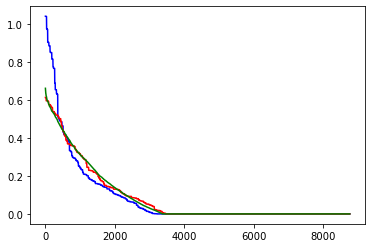

In [37]:
fig,ax = plt.subplots()
ax.plot(np.arange(0,8760,1),solar_NO.loc[:,'SOLAR'].sort_values(ascending=False), color='b')
ax.plot(np.arange(0,8760,1),T_H_TD_Borasio.loc[:,'SOLAR'].sort_values(ascending=False), color='r')
ax.plot(np.arange(0,8760,1),timeseries.loc[:,'SOLAR_NO'].sort_values(ascending=False), color='g')

In [38]:
solar_NO.sum()

0          0.000000
SOLAR    756.046087
dtype: float64

In [34]:
timeseries

,Electricity (%_elec)_NO,Space Heating (%_sh)_NO,Space Cooling (%_sc)_NO,Passanger mobility (%_pass)_NO,Freight mobility (%_freight)_NO,PV_NO,WIND_ONSHORE_NO,WIND_OFFSHORE_NO,HYDRO_DAM_NO,HYDRO_RIVER_NO,...,Passanger mobility (%_pass)_SO,Freight mobility (%_freight)_SO,PV_SO,WIND_ONSHORE_SO,WIND_OFFSHORE_SO,HYDRO_DAM_SO,HYDRO_RIVER_SO,SOLAR_SO,D_of_H,H_of_D
{PERIODS},,,,,,,,,,,,,,,,,,,,,
1,0.000072,0.000430,0.0,0.000006,0.000114,0.000188,0.362776,0.0001,0.033787,0.219106,...,0.000006,0.000114,0.0,0.731412,0.0001,0.033787,0.219106,0.0,1,1
2,0.000068,0.000417,0.0,0.000002,0.000114,0.000188,0.395756,0.0001,0.010146,0.196958,...,0.000002,0.000114,0.0,0.769478,0.0001,0.010146,0.196958,0.0,1,2
3,0.000064,0.000428,0.0,0.000001,0.000114,0.000188,0.395756,0.0001,0.008159,0.183511,...,0.000001,0.000114,0.0,0.827791,0.0001,0.008159,0.183511,0.0,1,3
4,0.000061,0.000432,0.0,0.000014,0.000114,0.000188,0.428736,0.0001,0.007950,0.175827,...,0.000014,0.000114,0.0,0.834400,0.0001,0.007950,0.175827,0.0,1,4
5,0.000059,0.000430,0.0,0.000038,0.000114,0.000188,0.461715,0.0001,0.008054,0.173228,...,0.000038,0.000114,0.0,0.853630,0.0001,0.008054,0.173228,0.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,0.000106,0.000285,0.0,0.000088,0.000114,0.000000,0.032980,0.0001,0.315900,0.329281,...,0.000088,0.000114,0.0,0.041520,0.0001,0.315900,0.329281,0.0,365,20
8757,0.000103,0.000299,0.0,0.000059,0.000114,0.000000,0.032980,0.0001,0.280545,0.282499,...,0.000059,0.000114,0.0,0.046676,0.0001,0.280545,0.282499,0.0,365,21
8758,0.000093,0.000308,0.0,0.000038,0.000114,0.000000,0.065959,0.0001,0.154498,0.234813,...,0.000038,0.000114,0.0,0.042982,0.0001,0.154498,0.234813,0.0,365,22


# Building timeseries from TDs

In [14]:
c='NO'
name = 'SOLAR'+'_'+c
ts = all_TD_ts[name]
ts.columns = np.arange(1,Nbr_TD+1) 
ts = ts*norm[name]/norm_TD[name]
ts.fillna(0, inplace=True)

In [25]:
solar_NO = pd.DataFrame(np.zeros((8760,1)))

In [28]:
for t in solar_NO.index:
    solar_NO.loc[t,'SOLAR'] =  ts.loc[T_H_TD.loc[t,'H_of_D'],T_H_TD.loc[t,'TD_of_day']]

In [31]:
TD_solar_NO_Borasio = pd.read_csv('TD_dec_solar_NO_Borasio.txt', sep='\t', header=None)